In [97]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

import pandas as pd
import numpy as np
import tflscripts
from tflscripts import boxplot_by, scatter_plot_by, heatmap_by
import matplotlib.patches as mpatches
import json
import pickle

configuration = tflscripts.read_configuration()
specificity_type = 'r'

df = pd.read_pickle('results_with_accuracy_classified_s' + specificity_type + '.p')
df = df.loc[df.first_predictions >= 0]

# for within device transfer, only use Mites
df = df.loc[((df.source_device_type == 'Mite') & (df.target_device_type == 'Mite') | (df.source_device_type != df.target_device_type))]


df['type_of_transfer'] = df.type_of_transfer.map({
    'Same device type in same place': 'A: replica',
    'Same device type in different place': 'B: placement',
    'Same device in different place': 'B: placement',
    'Same device type across spaces': 'C: room',
    'Same device across spaces': 'C: room',
    'Different device in same place': 'D: sensor board',
    'Same device in same place': '__remove__',
    'Different device in different place': '__remove__',
    'Different device across spaces': '__remove__',
    'No transfer': 'No transfer'
})

In [98]:
# performance metrics of the recommendations

source_threshold = 0.75
threshold = 0.95
specificity_column = 'specificity_for_retrained'

df['recommended'] = False
df.loc[(df.f1_wt >= source_threshold) & (df[specificity_column] >= threshold) & (df.predictions > 0), 'recommended'] = True

In [99]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score

actual = df.f1 >= 0.75
predicted = df.recommended

print('Precision', np.round(precision_score(actual, predicted, pos_label=True, average='binary'), 2))
print('Recall', np.round(recall_score(actual, predicted, pos_label=True, average='binary'), 2))
print('F1', np.round(f1_score(actual, predicted, pos_label=True, average='binary'), 2))
print('Accuracy', np.round(accuracy_score(actual, predicted), 2))

Precision 0.66
Recall 0.59
F1 0.62
Accuracy 0.97


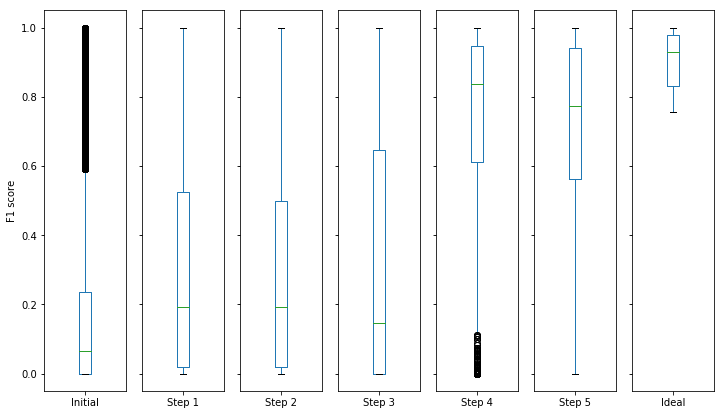

In [100]:
above_source_threshold = df.loc[df.f1_wt >= source_threshold]
# above_specificity_threshold = above_source_threshold.loc[above_source_threshold[specificity_column] >= threshold]
retrain_separated = df.loc[df.first_predictions == 1]

above_specificity_threshold = retrain_separated.loc[retrain_separated[specificity_column] >= threshold]
recommended = above_specificity_threshold.loc[above_specificity_threshold.predictions > 0]

drop_duplicates_by = ['transfer_with_label_key']

single_recommended = recommended.sort_values(by=['predictions', specificity_column], ascending=False)
single_recommended = single_recommended.drop_duplicates(drop_duplicates_by, keep='first')

ideal = df.loc[df.f1 >= 0.75]
ideal = ideal.sort_values(by=['f1'], ascending=False)
ideal = ideal.drop_duplicates(drop_duplicates_by, keep='first')

f, axes = plt.subplots(1, 7, sharex=False, sharey=True)

pd.DataFrame({'Initial': df.f1}).plot.box(ax=axes[0])
matplotlib.pyplot.sca(axes[0])
plt.ylabel('F1 score')

pd.DataFrame({'Step 1': above_source_threshold.f1}).plot.box(ax=axes[1])
matplotlib.pyplot.sca(axes[1])

pd.DataFrame({'Step 2': retrain_separated.f1}).plot.box(ax=axes[2])
matplotlib.pyplot.sca(axes[2])

pd.DataFrame({'Step 3': above_specificity_threshold.f1}).plot.box(ax=axes[3])
matplotlib.pyplot.sca(axes[3])

pd.DataFrame({'Step 4': recommended.f1}).plot.box(ax=axes[4])
matplotlib.pyplot.sca(axes[4])

pd.DataFrame({'Step 5': single_recommended.f1}).plot.box(ax=axes[5])
matplotlib.pyplot.sca(axes[5])

pd.DataFrame({'Ideal': ideal.f1}).plot.box(ax=axes[6])
matplotlib.pyplot.sca(axes[6])

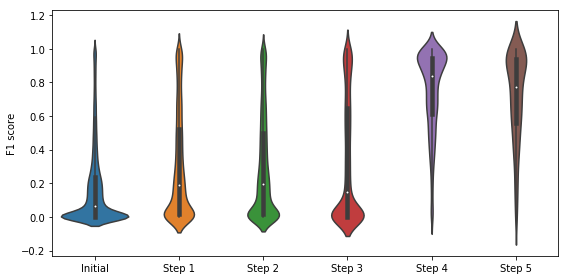

In [101]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (8, 4)

ax = sns.violinplot(x='Step', y='F1 score',
    data=pd.concat([
        pd.DataFrame({
            'Step': 'Initial',
            'F1 score': df.f1
        }),
        pd.DataFrame({
            'Step': 'Step 1',
            'F1 score': above_source_threshold.f1
        }),
        pd.DataFrame({
            'Step': 'Step 2',
            'F1 score': retrain_separated.f1
        }),
        pd.DataFrame({
            'Step': 'Step 3',
            'F1 score': above_specificity_threshold.f1
        }),
        pd.DataFrame({
            'Step': 'Step 4',
            'F1 score': recommended.f1
        }),
        pd.DataFrame({
            'Step': 'Step 5',
            'F1 score': single_recommended.f1
        }),
#         pd.DataFrame({
#             'Step': 'Ideal',
#             'F1 score': ideal.f1
#         })
    ]))
plt.xlabel('')

plt.tight_layout()

plt.savefig('../plots/pipeline_steps_distribution.pdf')
plt.show()

In [102]:
below_source_threshold = df.loc[df.f1_wt < source_threshold]
print('Count below source threshold', round(len(below_source_threshold) / len(df), 2))
print('F1', round(below_source_threshold.f1.mean(), 2))
print('std', round(below_source_threshold.f1.std(), 2))

Count below source threshold 0.71
F1 0.11
std 0.16


In [103]:
below_specificity_threshold = above_source_threshold.loc[above_source_threshold[specificity_column] < threshold]
print('Count below specificity threshold', round(len(below_specificity_threshold) / len(df), 2))
print('F1', round(below_specificity_threshold.f1.mean(), 2))
print('std', round(below_specificity_threshold.f1.std(), 2))

Count below specificity threshold 0.14
F1 0.24
std 0.22


In [104]:
not_recommended = above_specificity_threshold.loc[above_specificity_threshold.predictions == 0]
print('Not recommended', round(len(not_recommended) / len(df), 2))
print('F1', round(not_recommended.f1.mean(), 2))
print('std', round(not_recommended.f1.std(), 2))

Not recommended 0.14
F1 0.17
std 0.26


In [105]:
recommended_duplicates = recommended.loc[~recommended.index.isin(single_recommended.index)]
print('Duplicates', round(len(recommended_duplicates) / len(df), 2))
print('F1', round(recommended_duplicates.f1.mean(), 2))
print('std', round(recommended_duplicates.f1.std(), 2))

Duplicates 0.04
F1 0.75
std 0.24


In [106]:
print('Duplicates', round(len(single_recommended) / len(df), 2))
print('F1', round(single_recommended.f1.mean(), 2))
print('std', round(single_recommended.f1.std(), 2))

Duplicates 0.01
F1 0.71
std 0.26


In [107]:
print('True positive', len(np.intersect1d(ideal.key.values, single_recommended.key.values)))
print('False negative', len(np.setdiff1d(ideal.key.values, single_recommended.key.values)))
print('False positive', len(np.setdiff1d(single_recommended.key.values, ideal.key.values)))
# print('True negative', len(np.setdiff1d(single_recommended.key.values, ideal.key.values)))

True positive 153
False negative 148
False positive 168


In [108]:
# _df = df.loc[df.source_device_type == df.target_device_type]
_df = df

actual = _df.key.isin(ideal.key)
predicted = _df.key.isin(single_recommended.key)

print('Coverage')
print('Precision', np.round(precision_score(actual, predicted, pos_label=True, average='binary'), 2))
print('Recall', np.round(recall_score(actual, predicted, pos_label=True, average='binary'), 2))
print('F1', np.round(f1_score(actual, predicted, pos_label=True, average='binary'), 2))
print('Accuracy', np.round(accuracy_score(actual, predicted), 2))

mask_negative = actual == False
print('Specificity', np.round(accuracy_score(actual[mask_negative], predicted[mask_negative]), 2))

Coverage
Precision 0.51
Recall 0.55
F1 0.53
Accuracy 0.88
Specificity 0.93


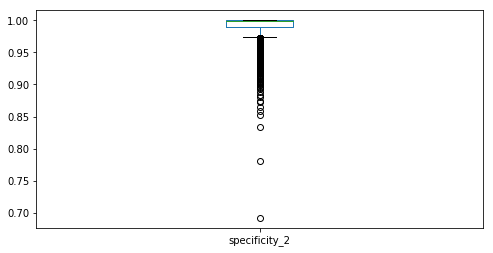

In [109]:
df.loc[df.f1 >= 0.75].specificity_2.plot.box()

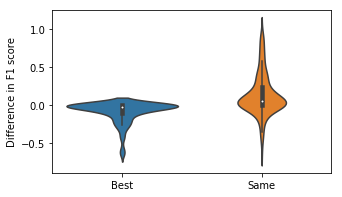

To best mean -0.09 std 0.14
To same mean 0.13 std 0.27


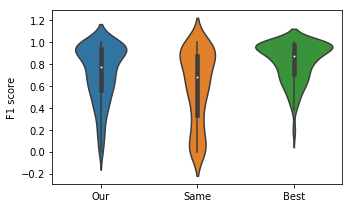

In [110]:
plt.rcParams["figure.figsize"] = (5, 3)

best_for_recommended_cases = df.sort_values(by=['f1'], ascending=False)
best_for_recommended_cases = best_for_recommended_cases.drop_duplicates(drop_duplicates_by, keep='first')
best_for_recommended_cases = best_for_recommended_cases.loc[best_for_recommended_cases.key.isin(single_recommended.key)]

same_for_recommended_cases = df.loc[df.classifier == 'SVM']
same_for_recommended_cases = same_for_recommended_cases.loc[same_for_recommended_cases.features_name == 'All']
same_for_recommended_cases = same_for_recommended_cases.drop_duplicates(drop_duplicates_by, keep='first')
same_for_recommended_cases = same_for_recommended_cases.loc[same_for_recommended_cases.key.isin(single_recommended.key)]

rec_f1 = pd.Series(single_recommended.f1.values,
          index=single_recommended.key)

best_f1 = pd.Series(best_for_recommended_cases.f1.values,
          index=best_for_recommended_cases.key)

same_f1 = pd.Series(same_for_recommended_cases.f1.values,
          index=same_for_recommended_cases.key)

best_diff = rec_f1 - best_f1
same_diff = rec_f1 - same_f1

# sns.violinplot(x=same_diff)
plt.xlabel('Difference between F1 score of ideal and recommended models')

ax = sns.violinplot(x='Step', y='Difference in F1 score',
    data=pd.concat([
        pd.DataFrame({
            'Step': 'Best',
            'Difference in F1 score': best_diff
        }),
        pd.DataFrame({
            'Step': 'Same',
            'Difference in F1 score': same_diff
        })
    ]))
plt.xlabel('')
plt.show()

ax = sns.violinplot(x='Step', y='F1 score',
    data=pd.concat([
        pd.DataFrame({
            'Step': 'Our',
            'F1 score': single_recommended.f1
        }),
        pd.DataFrame({
            'Step': 'Same',
            'F1 score': same_for_recommended_cases.f1
        }),
        pd.DataFrame({
            'Step': 'Best',
            'F1 score': best_for_recommended_cases.f1
        })
    ]))
plt.xlabel('')
plt.tight_layout()
plt.savefig('../plots/performance_on_recommendations.pdf')

print('To best', 'mean', round(best_diff.mean(), 2), 'std', round(best_diff.std(), 2))
print('To same', 'mean', round(same_diff.mean(), 2), 'std', round(same_diff.std(), 2))

In [111]:
best_recommended = recommended.sort_values(by=['f1'], ascending=False)
best_recommended = best_recommended.drop_duplicates(drop_duplicates_by, keep='first')

rec_f1 = pd.Series(best_recommended.f1.values,
          index=best_recommended.key)

best_f1 = pd.Series(best_for_recommended_cases.f1.values,
          index=best_for_recommended_cases.key)

best_diff = rec_f1 - best_f1

print('To best', 'mean', round(best_diff.mean(), 2), 'std', round(best_diff.std(), 2))

To best mean -0.04 std 0.09


Our 0.77 0.26
Same 0.15 0.29
Best 0.41 0.29
Ideal 0.93 0.08


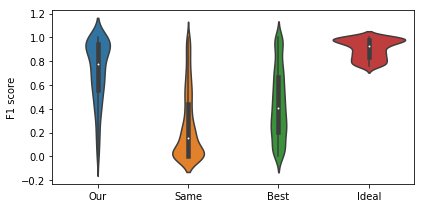

In [112]:
plt.rcParams["figure.figsize"] = (6, 3)

best_for_recommended_cases = df.sort_values(by=['f1'], ascending=False)
best_for_recommended_cases = best_for_recommended_cases.drop_duplicates(drop_duplicates_by, keep='first')
best_for_recommended_cases = best_for_recommended_cases.loc[best_for_recommended_cases.key.isin(single_recommended.key)]

same = df.loc[df.classifier == 'SVM']
same = same.loc[same.features_name == 'All']
same = same.drop_duplicates(drop_duplicates_by, keep='first')

best = df.sort_values(by=['f1'], ascending=False)
best = best.drop_duplicates(drop_duplicates_by, keep='first')

ax = sns.violinplot(x='Step', y='F1 score',
    data=pd.concat([
        pd.DataFrame({
            'Step': 'Our',
            'F1 score': single_recommended.f1
        }),
        pd.DataFrame({
            'Step': 'Same',
            'F1 score': same.f1
        }),
        pd.DataFrame({
            'Step': 'Best',
            'F1 score': best.f1
        }),
        pd.DataFrame({
            'Step': 'Ideal',
            'F1 score': ideal.f1
        })
    ]))
plt.xlabel('')

print('Our', round(single_recommended.f1.median(), 2), round(single_recommended.f1.std(), 2))
print('Same', round(same.f1.median(), 2), round(same.f1.std(), 2))
print('Best', round(best.f1.median(), 2), round(best.f1.std(), 2))
print('Ideal', round(ideal.f1.median(), 2), round(ideal.f1.std(), 2))

plt.tight_layout()

plt.savefig('../plots/performance_compared_techniques.pdf')
plt.show()

replica 0.85 0.27
placement 0.83 0.28
room 0.76 0.26
sensor_board 0.7 0.19


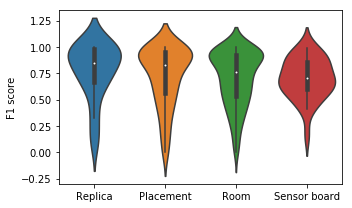

In [113]:
plt.rcParams["figure.figsize"] = (5, 3)

replica = single_recommended.loc[single_recommended.type_of_transfer == 'A: replica']
placement = single_recommended.loc[single_recommended.type_of_transfer == 'B: placement']
room = single_recommended.loc[single_recommended.type_of_transfer == 'C: room']
sensor_board = single_recommended.loc[single_recommended.type_of_transfer == 'D: sensor board']

ax = sns.violinplot(x='Step', y='F1 score',
    data=pd.concat([
        pd.DataFrame({
            'Step': 'Replica',
            'F1 score': replica.f1
        }),
        pd.DataFrame({
            'Step': 'Placement',
            'F1 score': placement.f1
        }),
        pd.DataFrame({
            'Step': 'Room',
            'F1 score': room.f1
        }),
        pd.DataFrame({
            'Step': 'Sensor board',
            'F1 score': sensor_board.f1
        })
    ]))
plt.xlabel('')

print('replica', round(replica.f1.median(), 2), round(replica.f1.std(), 2))
print('placement', round(placement.f1.median(), 2), round(placement.f1.std(), 2))
print('room', round(room.f1.median(), 2), round(room.f1.std(), 2))
print('sensor_board', round(sensor_board.f1.median(), 2), round(sensor_board.f1.std(), 2))

plt.tight_layout()

plt.savefig('../plots/predictions_performance_by_transfer_type.pdf')
plt.show()

1 median 0.77
2 median 0.83
3 median 0.84
4 median 0.86
5 median 0.87
6 median 0.88
for_retrained median 0.86


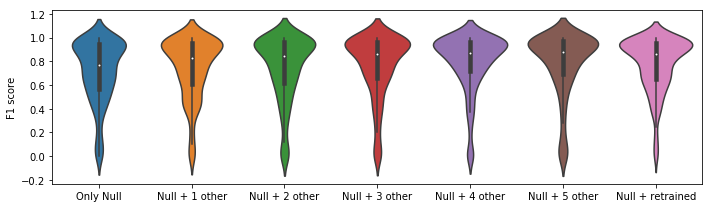

In [114]:
plt.rcParams["figure.figsize"] = (10, 3)

def recommendations_for_specificity(specificity, threshold):
    specificity_column = 'specificity_' + specificity

    file_ext = 'r' if specificity == 'for_retrained' else specificity
    _df = pd.read_pickle('results_with_accuracy_classified_s' + file_ext + '.p')
    _df = _df.loc[_df.predictions >= 0]
    _df = _df.loc[_df.f1_wt >= source_threshold]
    _df = _df.loc[_df[specificity_column] >= threshold]
    _df = _df.loc[_df.predictions > 0]

    drop_duplicates_by = ['source_placement', 'target_placement', 'source_room', 'target_room', 'source_device', 'target_device', 'label']

    _df = _df.sort_values(by=['predictions', specificity_column], ascending=False)
    _df = _df.drop_duplicates(drop_duplicates_by, keep='first')
    
    print(specificity, 'median', round(_df.f1.median(), 2))

    return _df

ax = sns.violinplot(x='Step', y='F1 score',
    data=pd.concat([
        pd.DataFrame({
            'Step': 'Only Null',
            'F1 score': recommendations_for_specificity('1', 0.95).f1
        }),
        pd.DataFrame({
            'Step': 'Null + 1 other',
            'F1 score': recommendations_for_specificity('2', 0.95).f1
        }),
        pd.DataFrame({
            'Step': 'Null + 2 other',
            'F1 score': recommendations_for_specificity('3', 0.95).f1
        }),
        pd.DataFrame({
            'Step': 'Null + 3 other',
            'F1 score': recommendations_for_specificity('4', 0.95).f1
        }),
        pd.DataFrame({
            'Step': 'Null + 4 other',
            'F1 score': recommendations_for_specificity('5', 0.95).f1
        }),
        pd.DataFrame({
            'Step': 'Null + 5 other',
            'F1 score': recommendations_for_specificity('6', 0.95).f1
        }),
        pd.DataFrame({
            'Step': 'Null + retrained',
            'F1 score': recommendations_for_specificity('for_retrained', 0.95).f1
        })
    ]))

plt.xlabel('')
plt.tight_layout()


plt.savefig('../plots/different_num_of_activities_for_specificity.pdf')
plt.show()